<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1.Importing the libraries </h2>
</div>

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role
import sys
import IPython
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import time
from time import sleep,gmtime,strftime
import os
import warnings
warnings.filterwarnings("ignore")


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
sagemaker.__version__

'2.192.0'

In [4]:
#lets check the other sagemaker properties
role=sagemaker.get_execution_role()
sess=sagemaker.Session()
region=boto3.session.Session().region_name
sm=boto3.Session().client('sagemaker')
print(f" region name is {region}")
print(role)
print(sm)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
 region name is us-east-1
arn:aws:iam::938401825592:role/service-role/AmazonSageMaker-ExecutionRole-20231117T141352


In [5]:
#import the sagemaker pacakges
#!pip install sagemaker-experiments
from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

### Define S3 bucket paths 

In [6]:
rawbucket=sess.default_bucket()   #s3bucket to store input/output files
prefix='sagemaker-spamdetection'
dataprefix = prefix + '/data'
traindataprefix = prefix + '/train_data'
testdataprefix = prefix + '/test_data'
testdatanolabelprefix = prefix + '/test_data_no_label'
trainheaderprefix = prefix + '/train_headers'

In [7]:
data=pd.read_csv("rawdata/spam.csv",encoding="ISO-8859-1")
data.shape

(5572, 5)

In [8]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2.Data Cleaning </h2>
</div>

In [9]:
#lets rename the column names and give them more understanding name
data.rename(columns={"v1":'label',"v2":"text"},inplace=True)
data.head()

,label,text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
#lets check the missing value counts
data.isna().sum()

label            0
text             0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

### Data Imputation Inference - this looks unnamed2,3,4 column has more than 99% data missing , lets drop this features 

In [11]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [12]:
#feature encoding - converting target categorical column into numerical

data['label']=data['label'].map({"ham":0,"spam":1})
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
#lets check & remove the duplicates
data.duplicated().sum()
data.drop_duplicates(keep='first')

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [14]:
#save the data to S3 bucket 
if not os.path.exists("rawdata/spam.csv"):
    !mkdir rawdata
    data.to_csv('rawdata/spam.csv',index=None)
else:
    pass

#upload the spam dataset to  s3 bucket
raw_data_location=sess.upload_data('rawdata',bucket=rawbucket,key_prefix=dataprefix)
print(raw_data_location)



s3://sagemaker-us-east-1-938401825592/sagemaker-spamdetection/data


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3.EDA </h2>
</div>

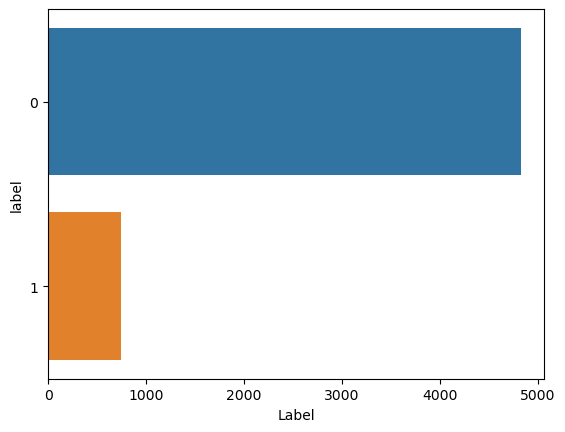

In [15]:
#plt.figure(figsize=(12,6))
data_eda=data.copy()
sns.countplot(data=data_eda,y='label')
plt.xlabel("Label")

plt.show()
import warnings
warnings.filterwarnings("ignore")

### Inference - label class is highly imbalanced 

In [16]:
#understand the sms text to check how many words, sentence and characters 
#!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
data_eda['num_characters']=data_eda['text'].apply(len) #getting the length of each sentence 
data_eda['num_words']=data_eda['text'].apply(lambda x : len(nltk.word_tokenize(x)))
data_eda['num_sentences']=data_eda['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
data_eda.describe()


,label,num_characters,num_words,num_sentences
count,5572.000000,5572.000000,5572.000000,5572.000000
mean,0.134063,80.118808,18.695621,1.970747
std,0.340751,59.690841,13.742587,1.417778
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,61.000000,15.000000,1.000000
75%,0.000000,121.000000,27.000000,2.000000
max,1.000000,910.000000,220.000000,28.000000


In [18]:
#spam and ham messages 
data_eda.groupby('label')[['num_characters','num_words','num_sentences']].describe().T

label                           0           1
num_characters count  4825.000000  747.000000
               mean     71.023627  138.866131
               std      58.016023   29.183082
               min       2.000000   13.000000
               25%      33.000000  132.500000
               50%      52.000000  149.000000
               75%      92.000000  157.000000
               max     910.000000  224.000000
num_words      count  4825.000000  747.000000
               mean     17.271917   27.891566
               std      13.988885    6.867007
               min       1.000000    2.000000
               25%       8.000000   25.000000
               50%      13.000000   29.000000
               75%      22.000000   32.000000
               max     220.000000   46.000000
num_sentences  count  4825.000000  747.000000
               mean      1.808705    3.017403
               std       1.328227    1.528449
               min       1.000000    1.000000
               25%       1.000000    2.000000
               50%       1.000000    3.000000
               75%       2.000000    4.000000
               max      28.000000    8.000000

<AxesSubplot:xlabel='num_sentences', ylabel='Count'>

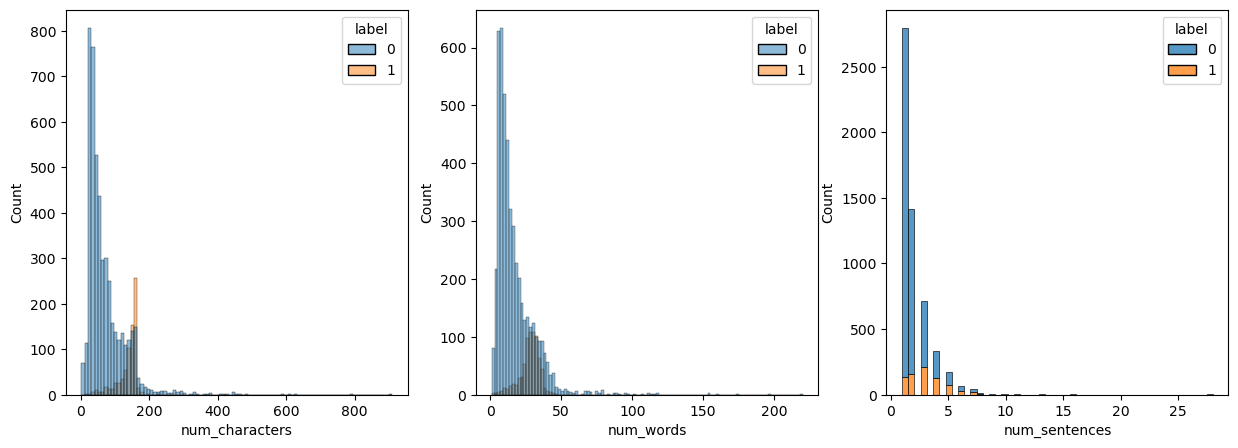

In [19]:
fix,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
sns.histplot(data=data_eda,x='num_characters',hue='label',ax=ax[0])
sns.histplot(data=data_eda,x='num_words',hue='label',ax=ax[1])
sns.histplot(data=data_eda,x='num_sentences',hue='label',ax=ax[2],bins=50,multiple='stack')

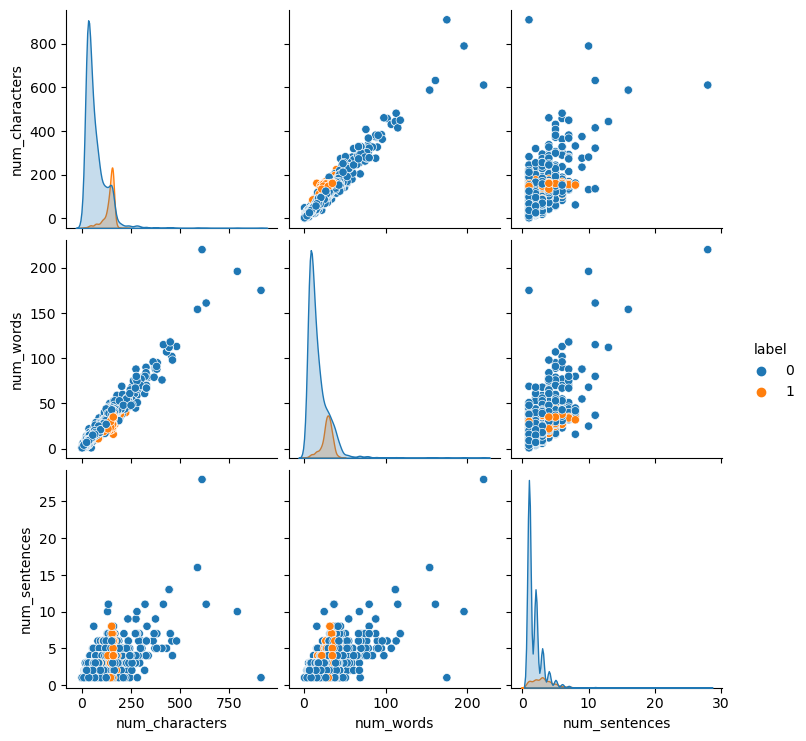

In [20]:
sns.pairplot(data_eda,hue='label')

<AxesSubplot:>

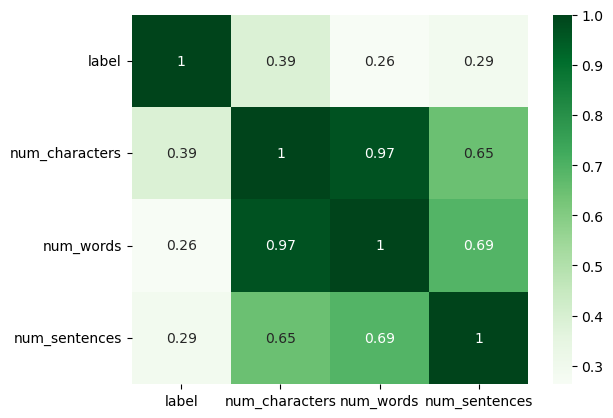

In [21]:
sns.heatmap(data_eda.corr(),annot=True,cmap='Greens')

In [22]:
#upload the EDAProcessed dataset to  s3 bucket
if not os.path.exists("rawdata/EDAprocessed.csv"):
    !mkdir rawdata
    print(f"saving data")
    data.to_csv('rawdata/EDAprocessed.csv',index=None)
else:
    pass


EDAprocessed_location=sess.upload_data('rawdata/EDAprocessed.csv',bucket=rawbucket,key_prefix=dataprefix)
print(EDAprocessed_location)



s3://sagemaker-us-east-1-938401825592/sagemaker-spamdetection/data/EDAprocessed.csv


### EDA  Inference - it looks there is correlation between characters, words and sentences also words count for spam are more compared to ham text 

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4.Pre processing </h2>
</div>

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
data_eda.shape

(5572, 5)

In [25]:
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()    

def transform_text(text):
    text=text.lower()
    y=[]
    #tokenization
    text=nltk.word_tokenize(text)
    for i in text:
        if i.isalnum():
            y.append(i)
    text=y[:]
    y.clear()
    #removing stopwords and punctuations
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text=y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    return y

data_eda['transformed_text']=data_eda['text'].apply(transform_text)


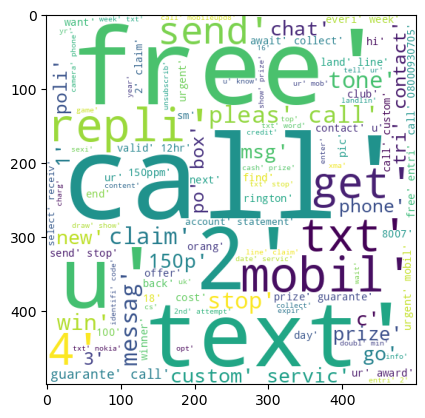

In [26]:
#!pip install wordcloud 
#lets check the most occuring words using wordcloud library
from wordcloud import WordCloud
wc=WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc=wc.generate(data_eda[data_eda['label']==1]['transformed_text'].astype('str').str.cat(sep=" "))
plt.imshow(spam_wc)




In [27]:
#counting the no of words repeating
spam_corpus=[]
for msg in data_eda[data_eda['label']==1]['transformed_text'].tolist():
    for word in msg:
        spam_corpus.append(word)
len(spam_corpus)
        

11490

Text(0.5, 1.0, 'top 30 repeating words in spam text')

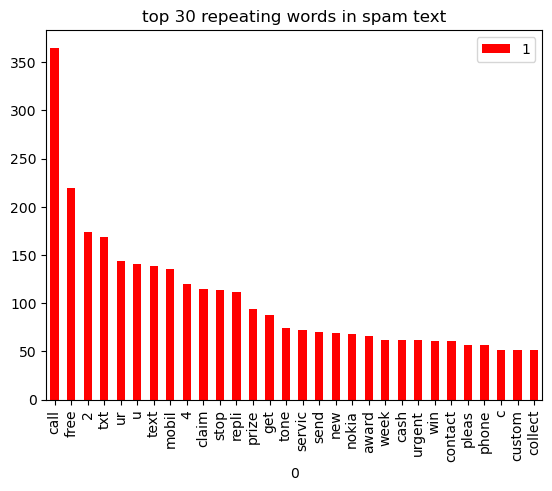

In [28]:
from collections import Counter
pd.DataFrame(Counter(spam_corpus).most_common(30)).plot(kind='bar',x=0,color='red')
plt.title("top 30 repeating words in spam text")

In [29]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv=CountVectorizer()
tf=TfidfVectorizer()
X=tf.fit_transform(data_eda['transformed_text'].astype('str')).toarray()
X.shape

(5572, 6708)

In [30]:
df_new=pd.DataFrame(X,columns=tf.get_feature_names())



In [31]:
from sklearn.model_selection import train_test_split
y=data_eda['label']
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int64

In [47]:
X_train,X_test,y_train,y_test=train_test_split(df_new,y,test_size=.3,random_state=33)

In [38]:
from sagemaker.sklearn.processing import SKLearnProcessor
sklearnpreprocessor=SKLearnProcessor(framework_version='0.20.0',
                                     role=role,instance_type='ml.t3.medium',
                                     instance_count=1)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [39]:
%%writefile data_preprocessing.py   
#the below entire code will be saved in this .py file and will be run on another server instance as created above 



import argparse
import os
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.exceptions import DataConversionWarning
#Lowercase,Tokenization,Removing Special chracters,Removing Stop words, Stemming
os.system('pip install nltk')
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
cv=CountVectorizer()


#defining the function for data preprocessing
def transform_text(text):
    text=text.lower()
    y=[]
    #tokenization
    text=nltk.word_tokenize(text)
    for i in text:
        if i.isalnum():
            y.append(i)
    text=y[:]
    y.clear()
    #removing stopwords and punctuations
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text=y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    return y


if __name__=='__main__':
    #passing input arguments and reading them args variable
    parser=argparse.ArgumentParser()
    parser.add_argument('--train-test-split-ratio',type=float,default=0.3)
    parser.add_argument('--random-split',type=int,default=0)
    args,_=parser.parse_known_args()
    print(f"Received arguments {args}")
    
    #reading the csv file from the path within instance 
    input_data_path=os.path.join('/opt/ml/processing/input','EDAprocessed.csv')
    print(f"reading data from {input_data_path}")
    df=pd.read_csv(input_data_path)
    print(df.shape)
    
    #function to perform data preprocessing
    df['transformed_text']=df['text'].apply(transform_text)
    X=df['transformed_text']
    y=df['label'].values
    
    #converting words to numerical form using Countvector
    print(f"converting words to numerical form using Countvector")
    X=cv.fit_transform(X.astype('str')).toarray()
    
    #creating X dataframe using above nd.array output with column names
    X=pd.DataFrame(X,columns=cv.get_feature_names())
    
    #assigning the args values to variables
    split_ratio=args.train_test_split_ratio
    random_state=args.random_split
    
    #train test split the dataframe 
    print(f"Train test split started ")
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=split_ratio,random_state=random_state)
    
    #concatting the train and test series into dataframe as one
    print(f"Type of X_train-{type(X_train)},y_train-{type(y_train)}")
    
    y_train=pd.Series(y_train,name='label')
    print(f"{y_train.shape}")
    train_full =pd.concat([y_train,X_train],axis=1)
    print(f" Train full shape -{train_full.shape}")
    
    test_full=pd.concat([pd.Series(y_test,name='label'),X_test],axis=1)
    
    print(f"Train data shape after preprocessing: {train_full.shape}")
    print(f"Test data shape after preprocessing: {test_full.shape}")
    
    
    #saving all dataframes in csv format to instance location
    train_features_headers_output_path=os.path.join('/opt/ml/processing/train_headers','train_data_with_headers.csv')
    train_features_output_path=os.path.join('/opt/ml/processing/train','train_data.csv')
    test_features_output_path=os.path.join('/opt/ml/processing/test','test_data.csv')
    print(f"saving training features to {train_features_output_path}")
    train_full.to_csv(train_features_output_path,header=False,index=False)
    
    print(f"saving training features with headers to {train_features_output_path}")
    train_full.to_csv(train_features_headers_output_path,index=False)
    
    print(f"saving test features to {train_features_output_path}")
    test_full.to_csv(test_features_output_path,header=False,index=False)
    print("Preprocessing Completed") 


Overwriting data_preprocessing.py


In [40]:
#copy the preprocessing.py code to s3 bucket
codeprefix=prefix + '/code'
codeupload=sess.upload_data('data_preprocessing.py',bucket=rawbucket,key_prefix=codeprefix)


### specify where the training and test data must be stored

In [41]:
#setting the s3 buckets information to output stored
train_data_location=rawbucket +'/'+ traindataprefix
test_data_location=rawbucket+'/'+ testdataprefix
print(f"Training data location -{train_data_location}")
print(f"Test data location - {test_data_location}")

Training data location -sagemaker-us-east-1-938401825592/sagemaker-spamdetection/train_data
Test data location - sagemaker-us-east-1-938401825592/sagemaker-spamdetection/test_data


### __Run The Pre-Processing Job__ 

In [42]:
from sagemaker.processing import ProcessingInput,ProcessingOutput
sklearnpreprocessor.run(code=codeupload,
                        inputs=[ProcessingInput(source=raw_data_location,destination='/opt/ml/processing/input')],
                        outputs=[ProcessingOutput(output_name='train_data',source='/opt/ml/processing/train',destination='s3://'+ train_data_location),
                                 ProcessingOutput(output_name='test_data',source='/opt/ml/processing/test',destination='s3://'+ test_data_location),
                                 ProcessingOutput(output_name='train_data_headers',source='/opt/ml/processing/train_headers',destination='s3://' + rawbucket + '/' + prefix +'/train_headers')],
                        arguments=['--train-test-split-ratio','0.2']
                       )
preprocessing_job_description=sklearnpreprocessor.jobs[-1].describe()
output_config = preprocessing_job_description['ProcessingOutputConfig']

for output in output_config['Outputs']:
    if output['OutputName'] == 'train_data':
        preprocessed_training_data = output['S3Output']['S3Uri']
    if output['OutputName'] == 'test_data':
        preprocessed_test_data = output['S3Output']['S3Uri']
                                        

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2023-11-23-17-59-25-113


......................................................................../miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.6/761.6 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 33.6 MB/s eta 0:00:00
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5.Model Building </h2>
</div>

In [48]:
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,roc_auc_score,classification_report

In [49]:
#since the label class is a categorical value we will use Multinomial NB and BernouliNB

bnb=BernoulliNB()
mnb=MultinomialNB()

bnb.fit(X_train,y_train)
y_pred1=bnb.predict(X_test)
y_pred_prob_1=bnb.predict_proba(X_test)
mnb.fit(X_train,y_train)
y_pred2=mnb.predict(X_test)
y_pred_prob_2=mnb.predict_proba(X_test)

In [50]:
from sklearn.metrics import accuracy_score,roc_auc_score,plot_roc_curve,RocCurveDisplay
def compute_evaluation_metric(X_test,y_actual,y_pred,y_pred_prob):
    cm=confusion_matrix(y_actual,y_pred,labels=y.value_counts().index)
    print(f"confusion matrix -\n {cm}\n")
    print(f"accuracy score : {accuracy_score(y_actual,y_pred)}")
    #print(f"macro averaged OvR AUC score : {roc_auc_score(y_actual,y_pred_prob,multi_class='ovr',average='macro')}")
    #way to find entire multiclass confusion matrix
    TP=(np.diag(cm))
    
    FP=(cm.sum(axis=0)-np.diag(cm))
    #print(FP)
    FN=(cm.sum(axis=1)-np.diag(cm))
    #print(FN)
    #print(f"cm sum -{cm.sum()}")
    TN=cm.sum()-(FP+FN+TP)
    #print(TN)
    
    TPR=np.round(np.mean(TP/(TP+FN)),4)
    TNR=np.round(np.mean(TN/(TN+FP)),4)
    FPR=np.round(np.mean(FP/(FP+TN)),4)
    print(f"TPR/Recall is {TPR}")
    print(f"TNR/Specifity is {TNR}")
    #print(f"FNR is {FNR}")
    print(f"FPR is {FPR}" )
    print(f"\n classification report - :\n {classification_report(y_actual,y_pred)}")
    ROC=roc_auc_score(y_actual,y_pred)
    print(f"ROC -{ROC} ") # ROC curve method for binary classification problems
    RocCurveDisplay.from_predictions(y_actual,y_pred)
    plt.show()

eval for multinomial model
confusion matrix -
 [[1449    0]
 [  71  152]]

accuracy score : 0.9575358851674641
TPR/Recall is 0.8408
TNR/Specifity is 0.8408
FPR is 0.1592

 classification report - :
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      1449
           1       1.00      0.68      0.81       223

    accuracy                           0.96      1672
   macro avg       0.98      0.84      0.89      1672
weighted avg       0.96      0.96      0.95      1672

ROC -0.8408071748878924 


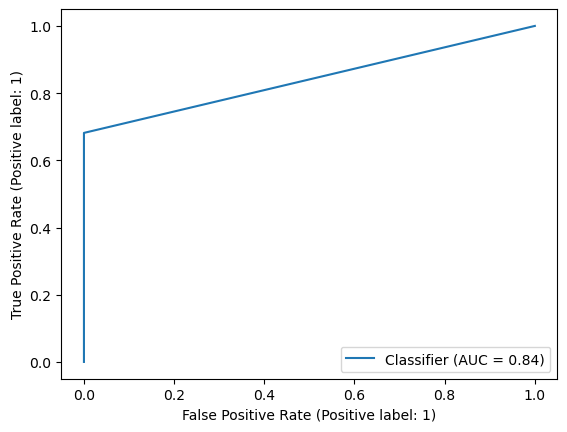

In [51]:
print(f"eval for multinomial model")
compute_evaluation_metric(X_test,y_test.values,y_pred2,y_pred_prob_2)

eval for bernouli model
confusion matrix -
 [[1445    4]
 [  50  173]]

accuracy score : 0.9677033492822966
TPR/Recall is 0.8865
TNR/Specifity is 0.8865
FPR is 0.1135

 classification report - :
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1449
           1       0.98      0.78      0.86       223

    accuracy                           0.97      1672
   macro avg       0.97      0.89      0.92      1672
weighted avg       0.97      0.97      0.97      1672

ROC -0.8865121144317869 


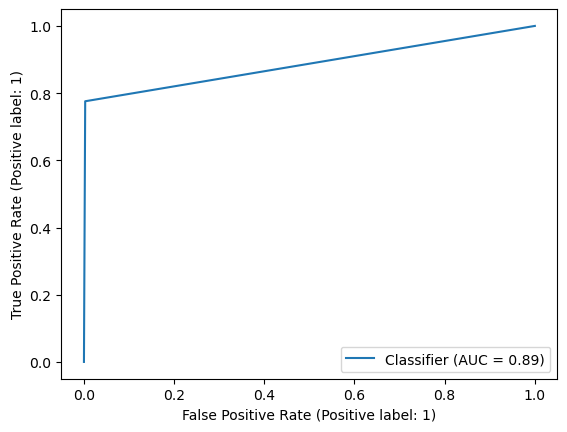

In [52]:
print(f"eval for bernouli model")
compute_evaluation_metric(X_test,y_test.values,y_pred1,y_pred_prob_1)